In [1]:
from google.colab import drive
import os
import tifffile
from PIL import Image
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.data import Dataset
from tensorflow.keras.layers import Normalization
from tensorflow.keras import  Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Activation,\
    BatchNormalization, Dropout, MaxPooling2D,\
    Conv2D, concatenate, Conv2DTranspose
import albumentations as A
from tensorflow.keras import metrics
from tensorflow.keras.losses import BinaryCrossentropy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
images_dir = "/content/drive/MyDrive/data/images"
masks_dir = "/content/drive/MyDrive/data/labels"

In [4]:
print(len(os.listdir(images_dir)))
print(len(os.listdir(masks_dir)))

306
456


In [53]:
img_list=[]
mask_list=[]
data_list=[]
image_files = os.listdir(images_dir)

for img_name in image_files:
  img_path = os.path.join(images_dir, img_name)
  mask_name = img_name.replace(".tif", ".png")
  mask_path = os.path.join(masks_dir, mask_name)

  img = tifffile.imread(img_path)
  mask = np.array(Image.open(mask_path))
  data_list.append((np.array(img,dtype=float),np.array(mask,dtype=int)))
  img_list.append(np.array(img,dtype=float))
  mask_list.append(np.array(mask,dtype=int))

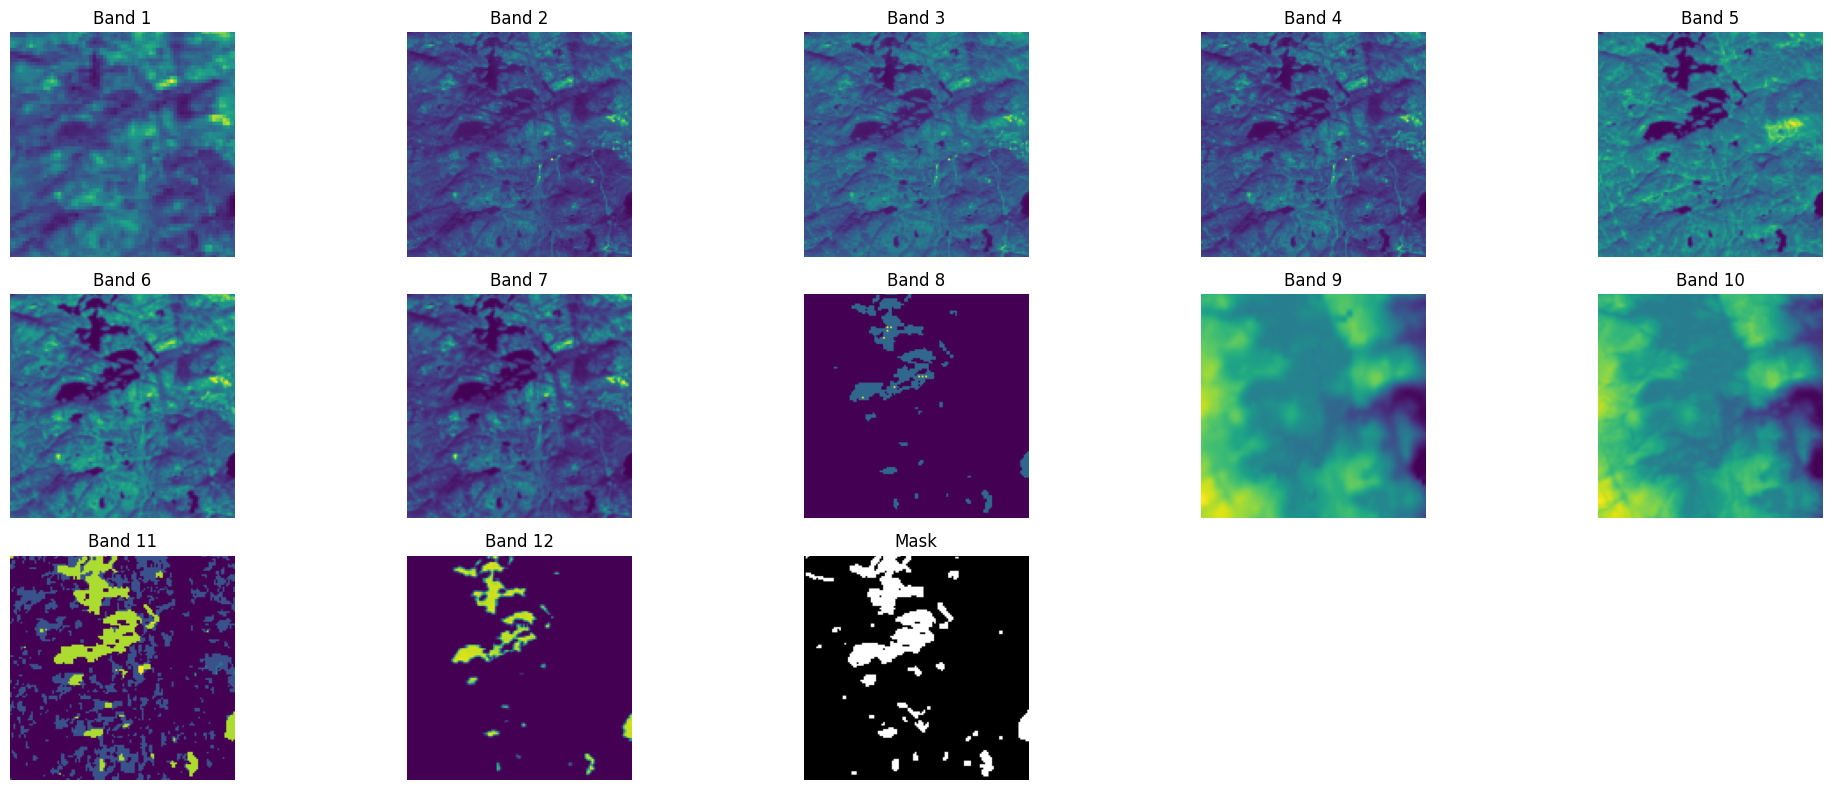

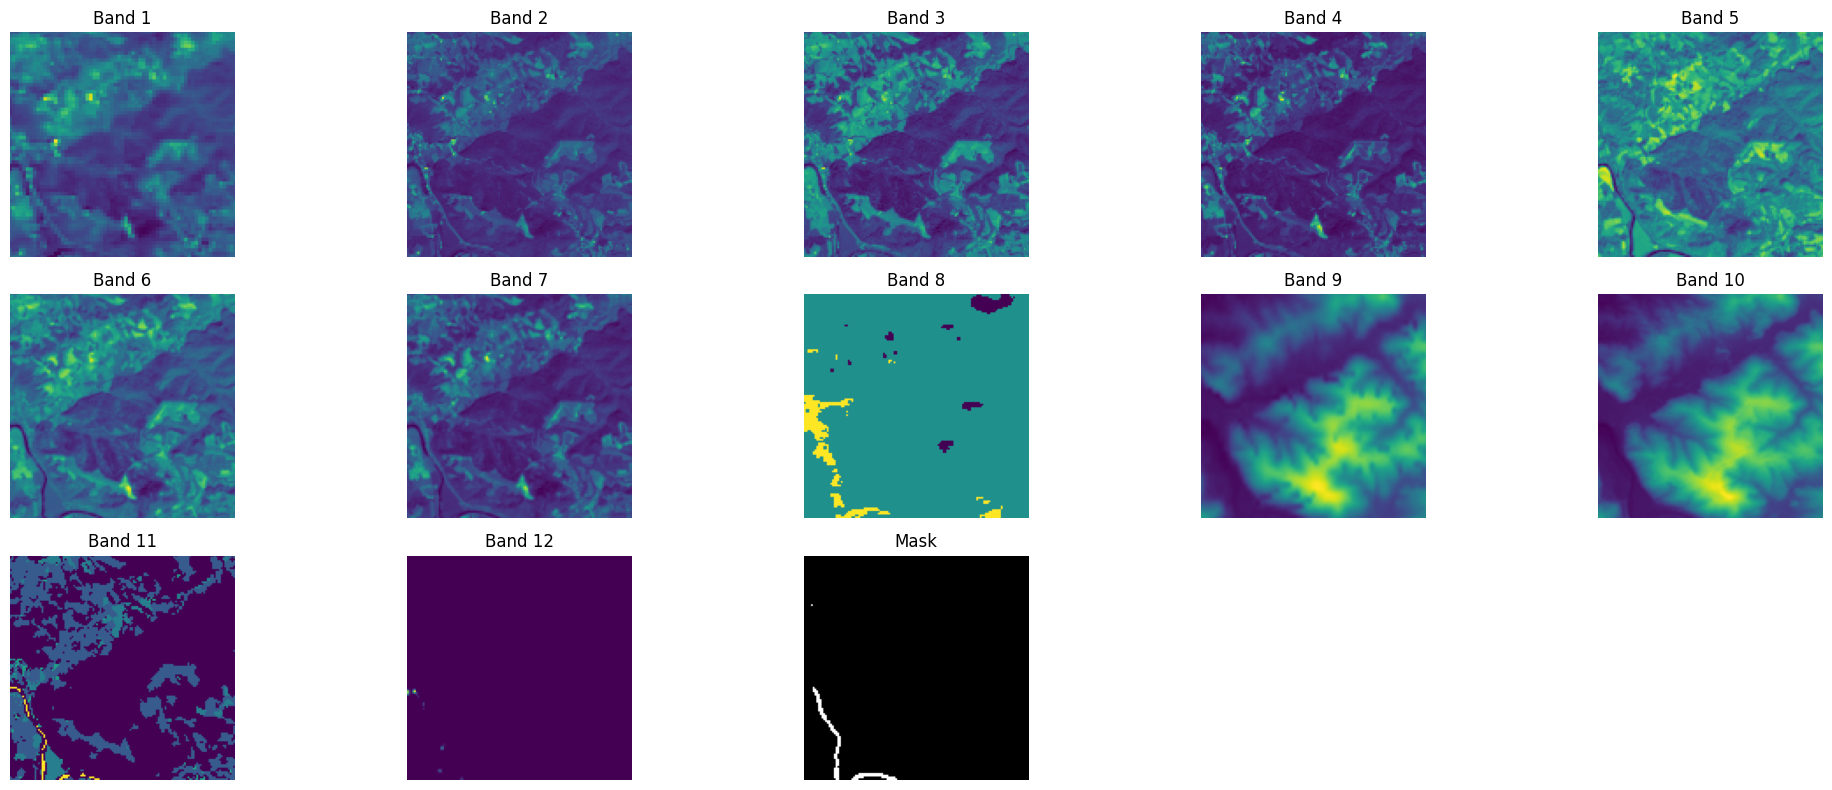

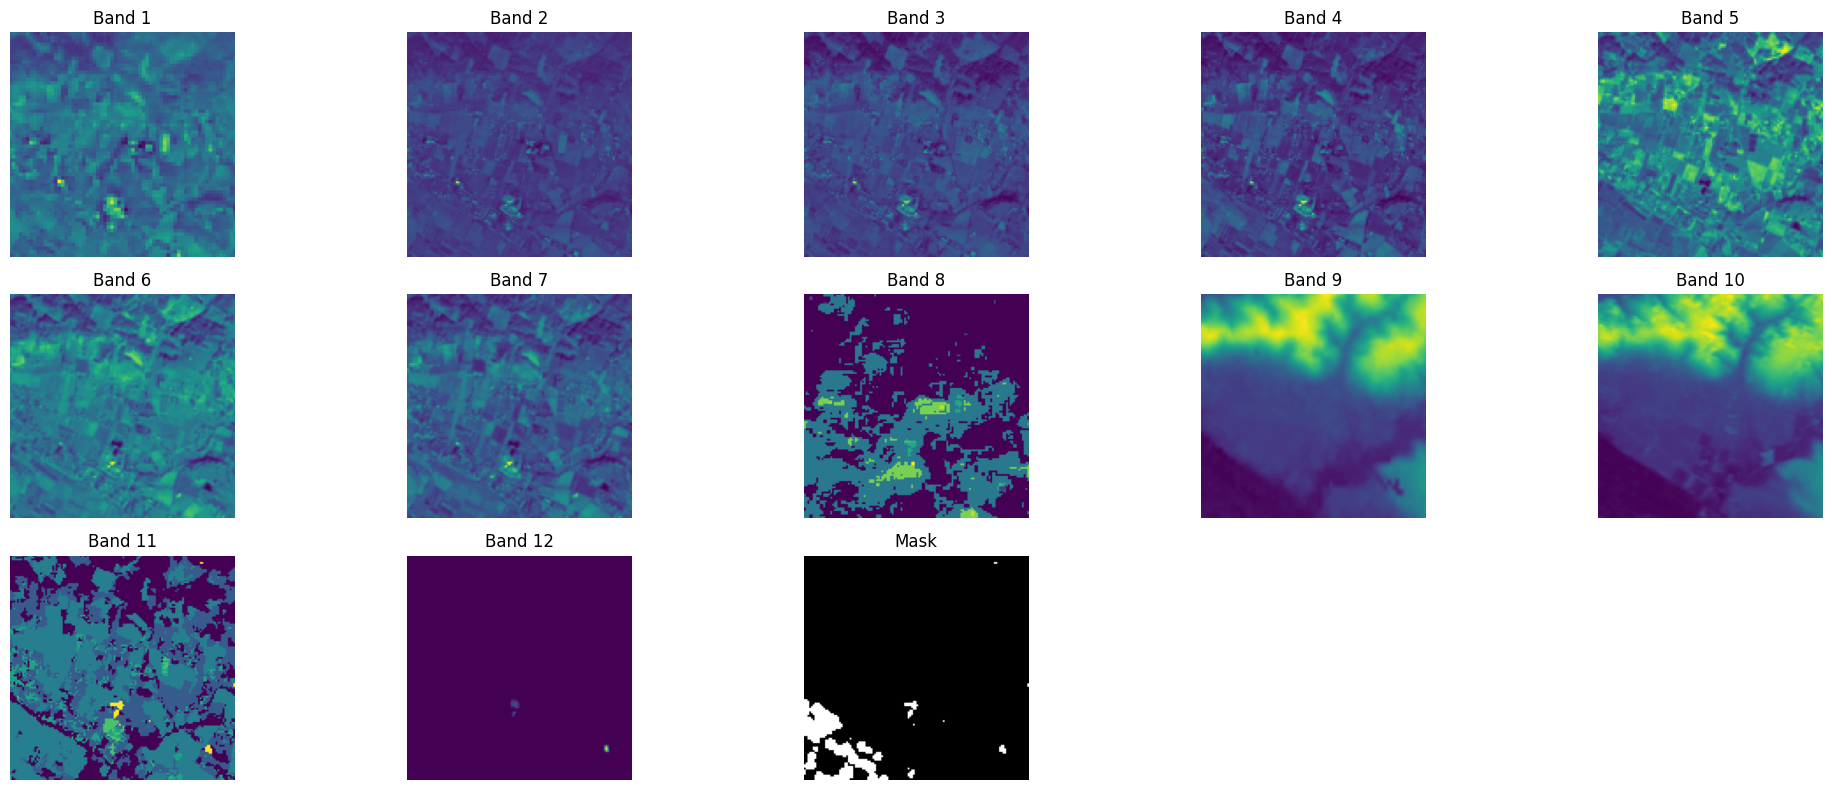

In [54]:
N = 3
for i in range(N):
    img = img_list[i]
    mask = mask_list[i]

    plt.figure(figsize=(20, 8))

    for b in range(12):
        plt.subplot(3, 5, b+1)
        plt.imshow(img[:, :, b], cmap="viridis")
        plt.axis("off")
        plt.title(f"Band {b+1}")

    plt.subplot(3, 5, 13)
    plt.imshow(mask, cmap="gray")
    plt.axis("off")
    plt.title("Mask")

    plt.tight_layout()
    plt.show()


In [55]:
def choose_channels(image):
    band_1 = image[..., 11]
    band_2 = image[..., 10]
    band_3 = image[..., 7]
    band_4 = image[..., 6]
    band_5 = image[..., 5]

    channels = [band_1, band_2, band_3, band_4, band_5]
    image_out = np.stack(channels, axis=-1)

    return image_out

In [56]:
img_list=[choose_channels(i) for i in img_list]

In [57]:
numofchannels=img_list[0].shape[-1]

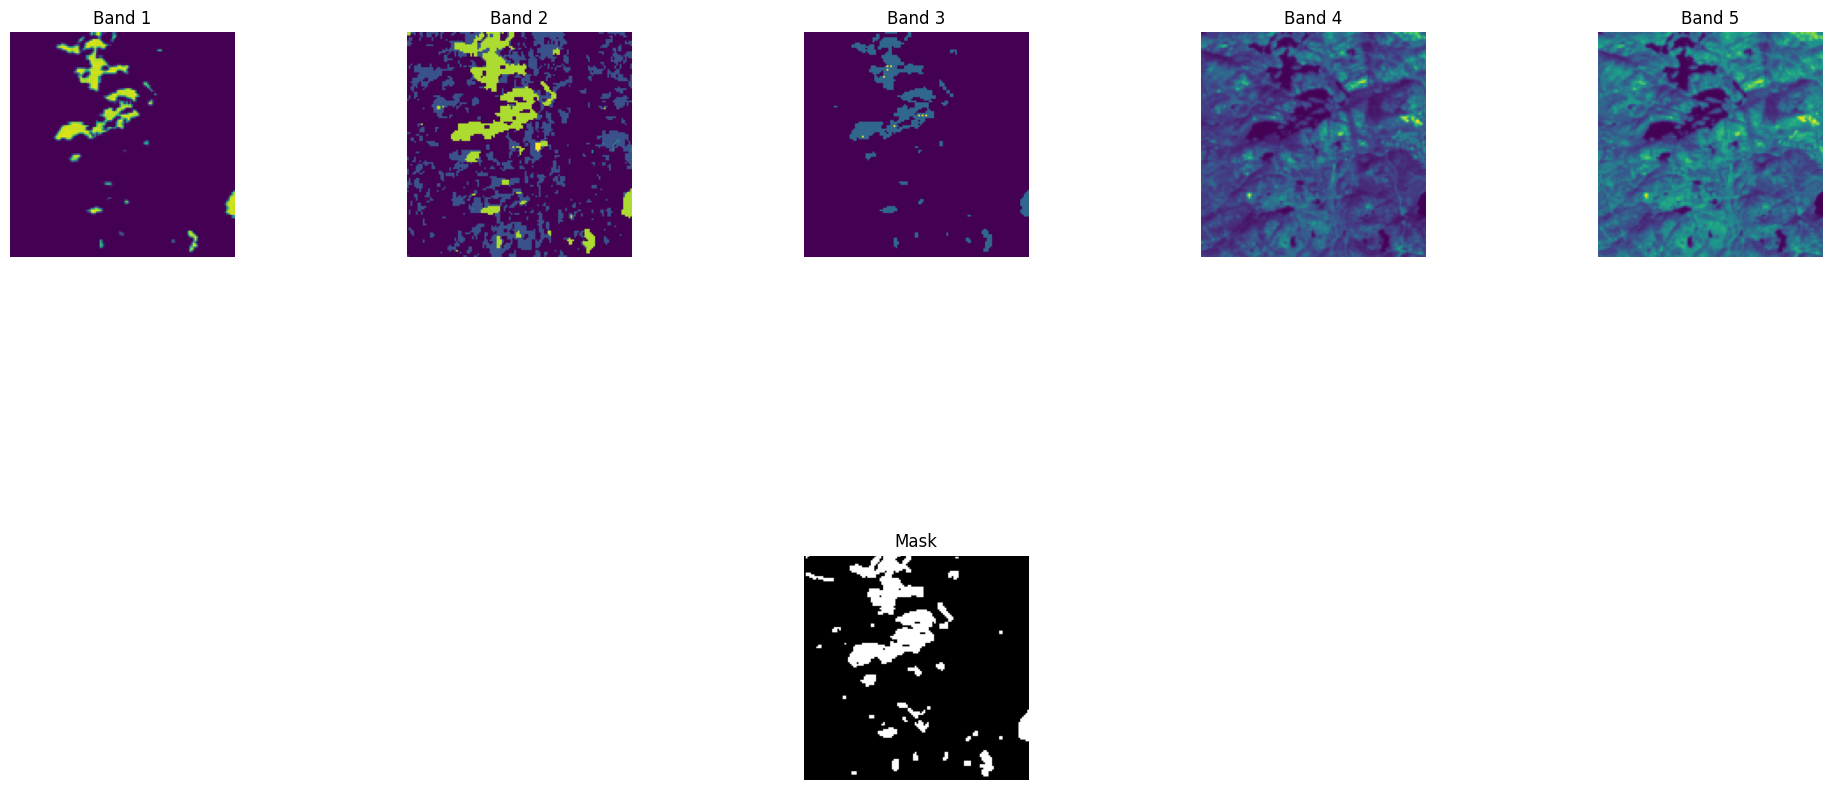

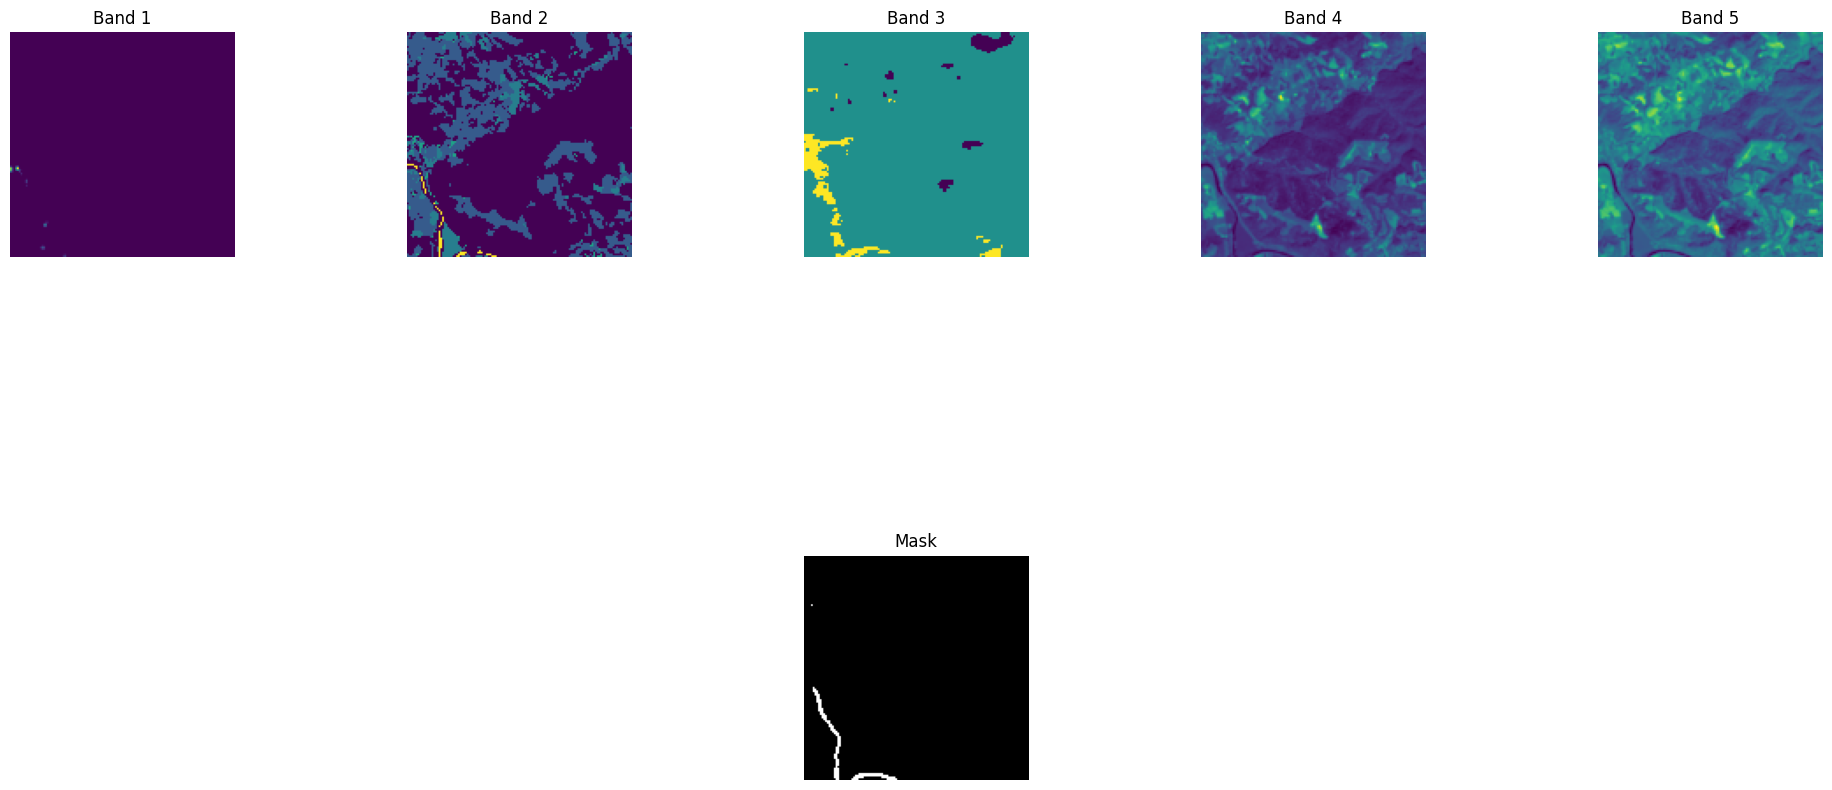

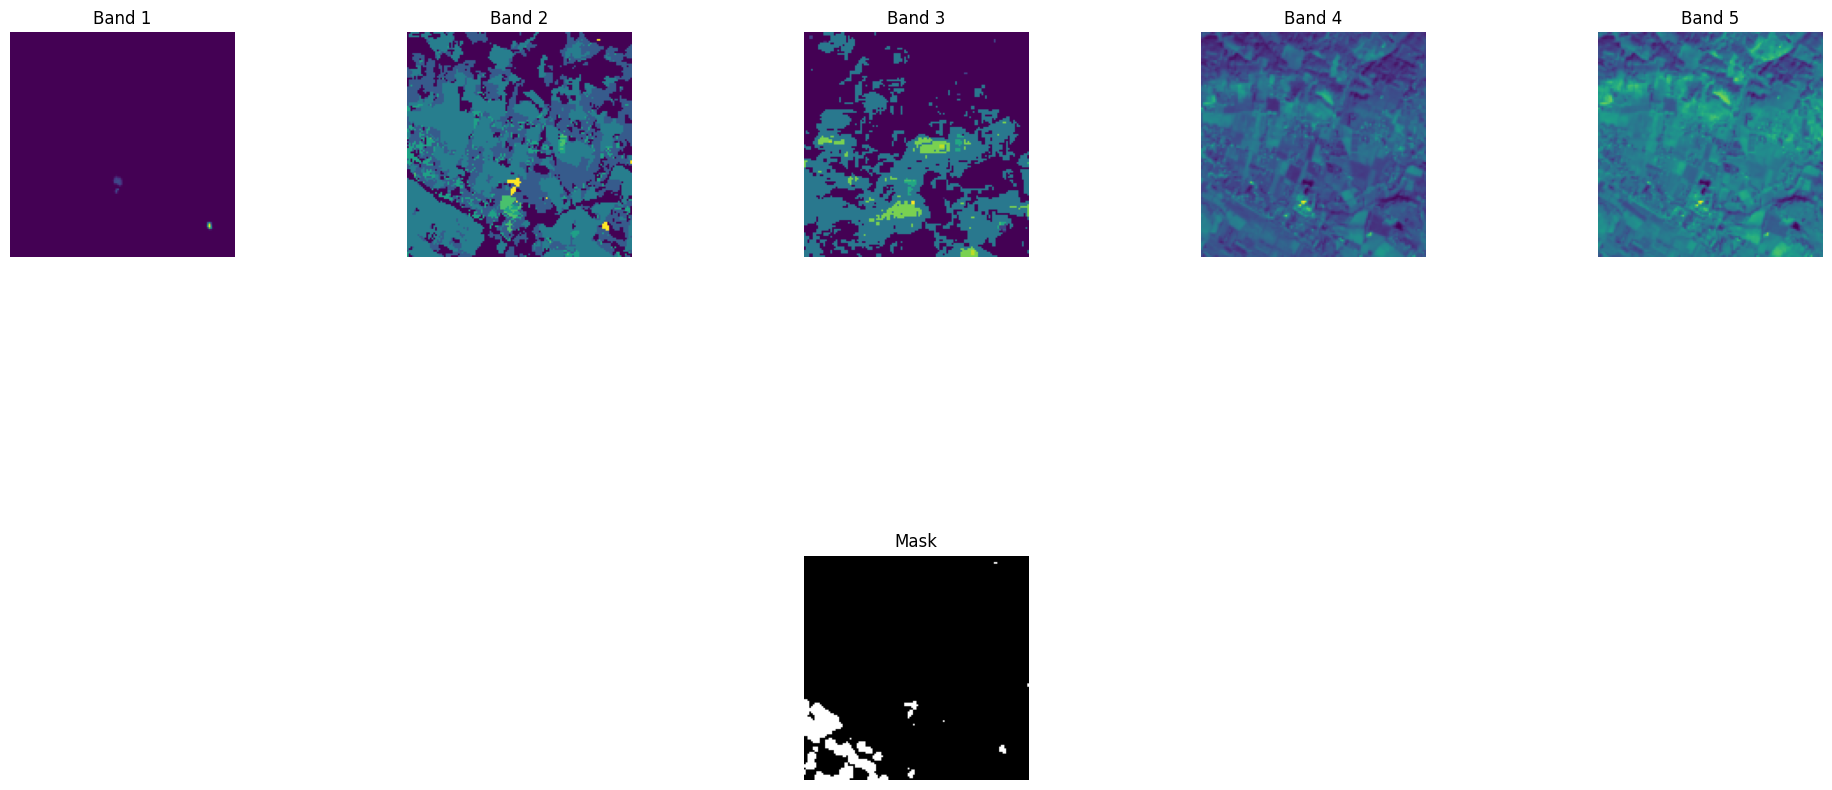

In [58]:
N = 3
for i in range(N):
    img = img_list[i]
    mask = mask_list[i]

    plt.figure(figsize=(20, 8))

    for b in range(numofchannels):
        plt.subplot(3, 5, b+1)
        plt.imshow(img[:, :, b], cmap="viridis")
        plt.axis("off")
        plt.title(f"Band {b+1}")

    plt.subplot(3, 5, 13)
    plt.imshow(mask, cmap="gray")
    plt.axis("off")
    plt.title("Mask")

    plt.tight_layout()
    plt.show()


In [16]:
for i in range(numofchannels):
  print(f"range before normailzation for channel {i} is {img_list[0][:,:,i].min()},{img_list[0][:,:,i].max()}")

range before normailzation for channel 0 is 14.0,532.0
range before normailzation for channel 1 is -28.0,846.0
range before normailzation for channel 2 is -2.0,1099.0
range before normailzation for channel 3 is 2.0,1297.0
range before normailzation for channel 4 is 46.0,4975.0
range before normailzation for channel 5 is 30.0,3786.0
range before normailzation for channel 6 is 16.0,3004.0
range before normailzation for channel 7 is 64.0,160.0
range before normailzation for channel 8 is 130.0,355.0
range before normailzation for channel 9 is 172.0,404.0
range before normailzation for channel 10 is 10.0,90.0
range before normailzation for channel 11 is 0.0,97.0


In [17]:
dir={i: [np.inf, -np.inf] for i in range(numofchannels)}
for img in img_list:
  for i in range(numofchannels):
    dir[i][0]=min(img[:,:,i].min(),dir[i][0])
    dir[i][1]=max(img[:,:,i].max(),dir[i][1])

In [ ]:
dir

{0: [np.float64(-167.0), np.float64(1215.0)],
 1: [np.float64(52.0), np.float64(1493.0)],
 2: [np.float64(-0.8896787034404322), np.float64(-0.1238702817650186)],
 3: [np.float64(133.0), np.float64(3311.0)],
 4: [np.float64(67.0), np.float64(1847.0)],
 5: [np.float64(0.0), np.float64(83.0)]}

In [18]:
for img in img_list :
  for i in range(numofchannels):
    img[:,:,i]=(img[:,:,i]-dir[i][0])/(dir[i][1]-dir[i][0])

In [19]:
for i in range(numofchannels):
  print(f"range after normailzation for channel {i} is {img_list[0][:,:,i].min()},{img_list[0][:,:,i].max()}")

range after normailzation for channel 0 is 0.17673659088054264,0.24180379349327974
range after normailzation for channel 1 is 0.07786768205616373,0.16106615897191814
range after normailzation for channel 2 is 0.049013047842087654,0.1411007025761124
range after normailzation for channel 3 is 0.04965266814019577,0.1518787496053047
range after normailzation for channel 4 is 0.02817941303144035,0.3314465021842121
range after normailzation for channel 5 is 0.02165948968442702,0.2630631788675365
range after normailzation for channel 6 is 0.01541049798115747,0.21648721399730822
range after normailzation for channel 7 is 0.0,0.5026178010471204
range after normailzation for channel 8 is 0.7111064307778714,0.7269025554619489
range after normailzation for channel 9 is 0.03832671184856275,0.09254498714652956
range after normailzation for channel 10 is 0.0,0.8888888888888888
range after normailzation for channel 11 is 0.0,0.8738738738738738


In [59]:
train_imgs, temp_img, train_masks, temp_masks = train_test_split(
    img_list, mask_list, test_size=0.2, random_state=43
)
test_imgs, val_imgs, test_masks, val_masks = train_test_split(
    temp_img, temp_masks, test_size=0.5, random_state=43
)

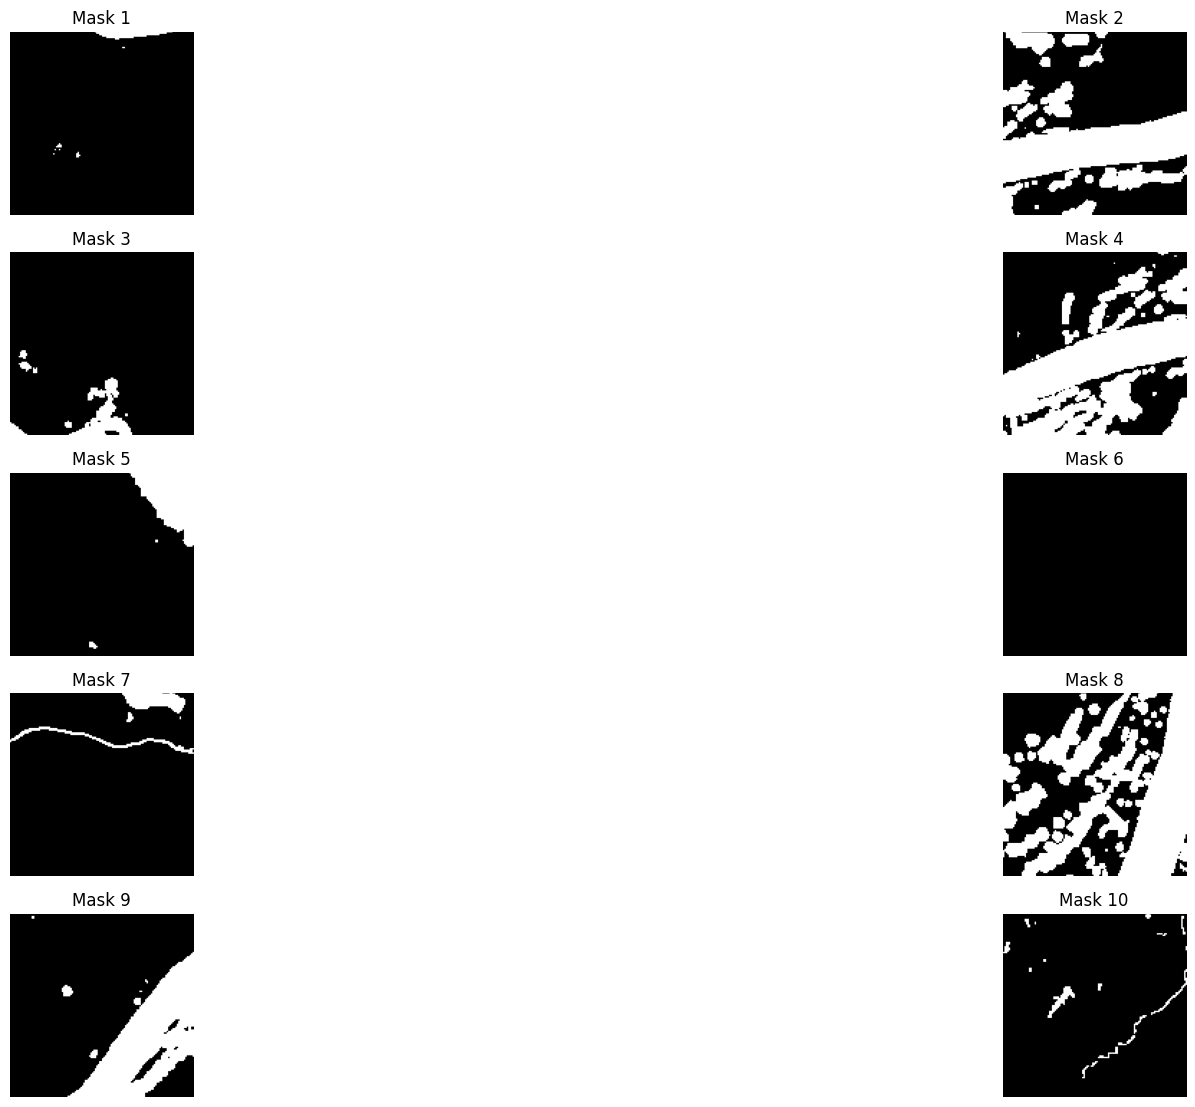

In [62]:
plt.figure(figsize=(20, 20))
for i in range(10):
    mask = val_masks[i]

    plt.subplot(9, 4, 2*i+2)
    plt.imshow(mask, cmap="gray")
    plt.axis("off")
    plt.title(f"Mask {i+1}")

plt.tight_layout()
plt.show()

In [63]:
len(train_imgs), len(val_imgs), len(test_imgs), len(train_masks),len(val_masks) ,len(test_masks)

(244, 31, 31, 244, 31, 31)

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5)
])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
augmented_images = []
augmented_masks = []

for img, mask in zip(train_imgs, train_masks):
    augmented = transform(image=img, mask=mask)
    augmented_images.append(augmented['image'])
    augmented_masks.append(augmented['mask'])

train_imgs = train_imgs + augmented_images
train_masks = train_masks + augmented_masks


In [64]:
print(f'shape of image {train_imgs[0].shape}'),print(f'shape of mask {train_masks[0].shape}')

shape of image (128, 128, 5)
shape of mask (128, 128)


(None, None)

In [65]:
BASE_FILTERS = 32
INPUT_SIZE   = (128, 128, numofchannels)
DROPOUT      = 0
ACTIVATION   = 'relu'
INITIALIZER = 'he_normal'
normalizer = Normalization()

input_layer = Input(INPUT_SIZE)
x = normalizer(input_layer)

c1 = Conv2D(BASE_FILTERS, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (x)
c1 = BatchNormalization()(c1)
c1 = Dropout(DROPOUT)(c1)
c1 = Conv2D(BASE_FILTERS, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(BASE_FILTERS * 2, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(DROPOUT)(c2)
c2 = Conv2D(BASE_FILTERS * 2, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(BASE_FILTERS * 4, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(DROPOUT)(c3)
c3 = Conv2D(BASE_FILTERS * 4, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(BASE_FILTERS * 8, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(DROPOUT)(c4)
c4 = Conv2D(BASE_FILTERS * 8, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(BASE_FILTERS * 16, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(DROPOUT)(c5)
c5 = Conv2D(BASE_FILTERS * 16, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c5)
c5 = BatchNormalization()(c5)

u6 = Conv2DTranspose(BASE_FILTERS * 8, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(BASE_FILTERS * 8, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(DROPOUT)(c6)
c6 = Conv2D(BASE_FILTERS * 8, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c6)
c6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(BASE_FILTERS * 4, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(BASE_FILTERS * 4, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(DROPOUT)(c7)
c7 = Conv2D(BASE_FILTERS * 4, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c7)
c7 = BatchNormalization()(c7)

u8 = Conv2DTranspose(BASE_FILTERS * 2, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(BASE_FILTERS * 2, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(DROPOUT)(c8)
c8 = Conv2D(BASE_FILTERS * 2, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c8)
c8 = BatchNormalization()(c8)

u9 = Conv2DTranspose(BASE_FILTERS, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(BASE_FILTERS, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(DROPOUT)(c9)
c9 = Conv2D(BASE_FILTERS, (3, 3), activation=ACTIVATION, kernel_initializer=INITIALIZER, padding='same') (c9)

ouput_layer = Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = Model(inputs=[input_layer], outputs=[ouput_layer])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 128, 128,  │         11 │ input_layer_2[0]… │
│ (Normalization)     │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 128, 128,  │      1,472 │ normalization_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_18[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_19[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 7,772,332 (29.65 MB)

 Trainable params: 7,766,497 (29.63 MB)

 Non-trainable params: 5,835 (22.80 KB)

In [74]:

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=BinaryCrossentropy(),
    metrics=["accuracy"]
)

In [75]:
checkpoint = ModelCheckpoint(
    filepath='Water Segmentation.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [76]:
type(train_imgs),type(train_masks),type(val_imgs),type(val_masks)

(list, list, list, list)

In [77]:
history = model.fit(
    np.array(train_imgs),
    np.array(train_masks),
    validation_data=(np.array(val_imgs),np.array(val_masks)),
    batch_size=16,
    epochs=100,
    callbacks=[checkpoint]
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.7912 - loss: 0.4870
Epoch 1: val_loss improved from inf to 0.44734, saving model to Water Segmentation.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7913 - loss: 0.4871 - val_accuracy: 0.8146 - val_loss: 0.4473
Epoch 2/100
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8009 - loss: 0.4712
Epoch 2: val_loss improved from 0.44734 to 0.42950, saving model to Water Segmentation.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.8010 - loss: 0.4707 - val_accuracy: 0.8229 - val_loss: 0.4295
Epoch 3/100
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8108 - loss: 0.4534
Epoch 3: val_loss improved from 0.42950 to 0.41553, saving model to Water Segmentation.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 270ms/step - accuracy: 0.8114 - loss: 0.4529 - val_accuracy: 0.8299 - val_loss: 0.4155
Epoch 4/100
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8221 - loss: 0.4360
Epoch 4: val_loss improved from

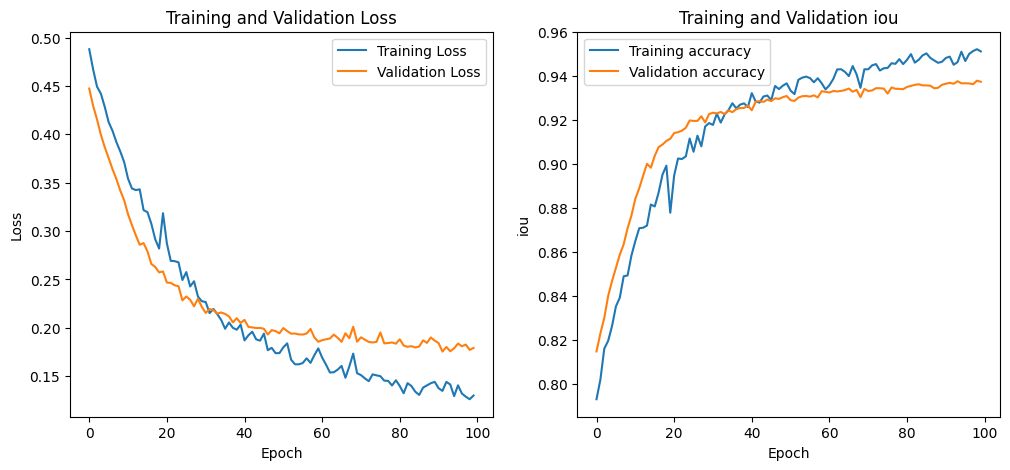

In [78]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('iou')
plt.legend()
plt.title('Training and Validation iou')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


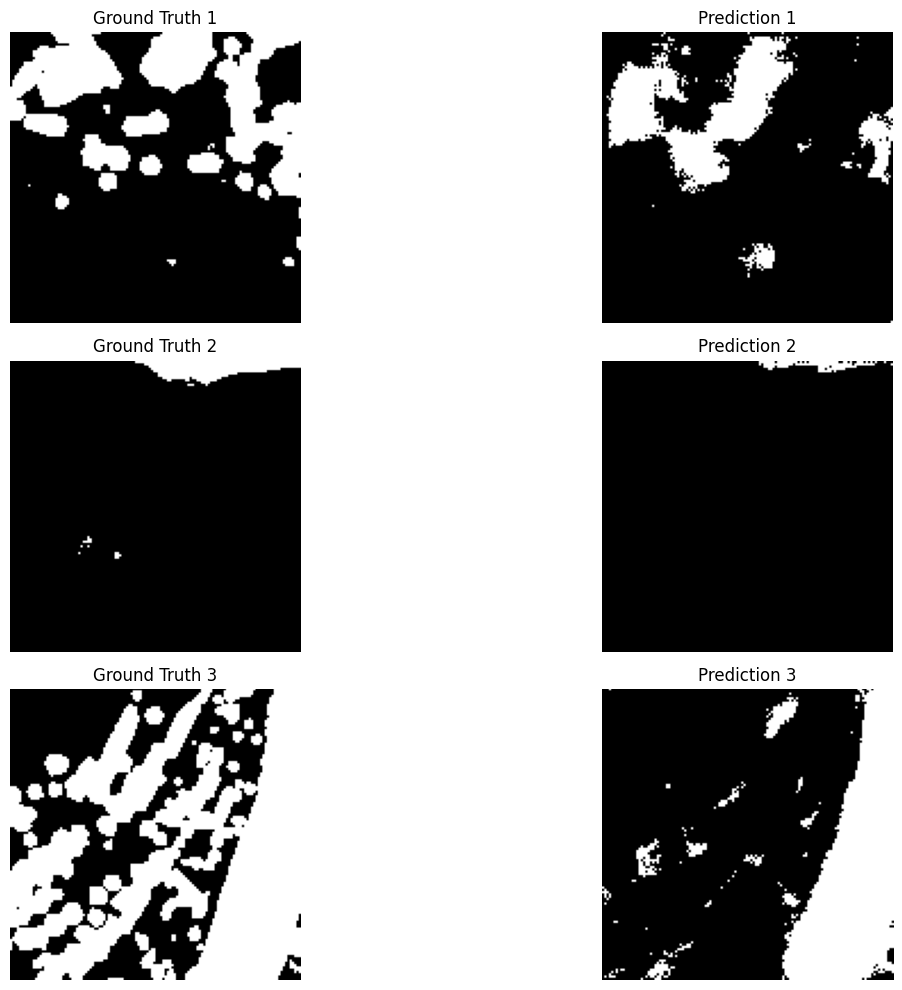

In [79]:
plt.figure(figsize=(15, 10))
predict = model.predict(np.array(test_imgs))
predict_bin = (predict > 0.5).astype(np.uint8)

for i in range(3):
    mask = test_masks[i]
    pred = predict_bin[i].squeeze()

    plt.subplot(3, 2, 2*i+1)
    plt.imshow(mask, cmap="gray")
    plt.title(f"Ground Truth {i+1}")
    plt.axis("off")

    plt.subplot(3, 2, 2*i+2)
    plt.imshow(pred, cmap="gray")
    plt.title(f"Prediction {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [80]:
loss, acc = model.evaluate(np.array(test_imgs), np.array(test_masks))
print("Test Loss:", loss)
print("Test Accuracy:", acc)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9081 - loss: 0.2589
Test Loss: 0.2589039206504822
Test Accuracy: 0.9080967903137207
